In [105]:
# -1-) Notlar
"""
    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.

    Yapilmasi gerekenler:
        - Bu grafiklere trend tahmin gibi şeyler uygulamaya calis
        - Farkli grafikler cikartmaya calis.
        - ML.
        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka
        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.

    Sorunlar:
        - Weather'da degerler gunluk ortalama seklinde. 1 saat firtina olsa sonra tum gun yagmur yagmasa o gunun
        ortalamasi az olur. Burada farkli bir yontem bul.
        Mesela gunluk toplami almak olabilir.
        Gunluk maks min alinabilir
"""
# 1-) read and preproccess train.csv
# 2-) extract ilce and keep preprocessing train.csv
# 3-) read and preprocess weather.csv
# 4-) read and preprocess holidays.csv
# 5-) merge the train data and holidays, return a new dict called dict_holiday
# 6-) merge the dict_holiday and weather, return merged_all which contains all of the required columns
# 7-) Her ilcenin Bildirimli+Bildirimsiz kesinti grafigi
# 8-) Her ilcenin Bildirimsiz+MHO(EWMA) kesinti grafiği
# 9-) ort. yagis miktarlari icin ort. kesinti sayisi grafigi (cok mantikli ve gerekli degil)
# 10-) test icin birlestirme islemleri

"\n    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.\n\n    Yapilmasi gerekenler:\n        - Bu grafiklere trend tahmin gibi şeyler uygulamaya calis\n        - Farkli grafikler cikartmaya calis.\n        - ML.\n        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka\n        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.\n\n    Sorunlar:\n        - Weather'da degerler gunluk ortalama seklinde. 1 saat firtina olsa sonra tum gun yagmur yagmasa o gunun\n        ortalamasi az olur. Burada farkli bir yontem bul.\n        Mesela gunluk toplami almak olabilir.\n        Gunluk maks min alinabilir\n"

In [106]:
# 0-) Import required moduls and libraries

# bildirimisiz_sum tahmin edilecek

import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import os
from unidecode import unidecode # to convert Turkish characters to English
from statsmodels.tsa.seasonal import seasonal_decompose as sm
import statsmodels.api as sa
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Flatten 
from keras.layers import Dense 
from keras.layers import Activation
from keras.layers import LSTM

In [107]:
# 1-) read and preproccess train.csv
train = pd.read_csv("./train.csv", low_memory=False) # 46.944 satir, 4 kolon

# print(train) # 1.098 farkli tarih var, 47 farkli ilce var

tarihler = []
for i in train["tarih"]:
    tarihler.append(datetime.strptime(i, "%Y-%m-%d"))
train["tarih"] = tarihler

# print(train.dtypes)

dict = {}
for label, group in train.groupby("ilce"):
    dict[label] = group

ilceler = (list(dict.keys()))
print(dict.keys()) # keys olarak her ilceyi, values olarak o ilcelerin bulundugu satirlari icerir

dict_keys(['izmir-aliaga', 'izmir-balcova', 'izmir-bayindir', 'izmir-bayrakli', 'izmir-bergama', 'izmir-beydag', 'izmir-bornova', 'izmir-buca', 'izmir-cesme', 'izmir-cigli', 'izmir-dikili', 'izmir-foca', 'izmir-gaziemir', 'izmir-guzelbahce', 'izmir-karabaglar', 'izmir-karaburun', 'izmir-karsiyaka', 'izmir-kemalpasa', 'izmir-kinik', 'izmir-kiraz', 'izmir-konak', 'izmir-menderes', 'izmir-menemen', 'izmir-narlidere', 'izmir-odemis', 'izmir-seferihisar', 'izmir-selcuk', 'izmir-tire', 'izmir-torbali', 'izmir-urla', 'manisa-ahmetli', 'manisa-akhisar', 'manisa-alasehir', 'manisa-demirci', 'manisa-golmarmara', 'manisa-gordes', 'manisa-kirkagac', 'manisa-koprubasi', 'manisa-kula', 'manisa-salihli', 'manisa-sarigol', 'manisa-saruhanli', 'manisa-sehzadeler', 'manisa-selendi', 'manisa-soma', 'manisa-turgutlu', 'manisa-yunusemre'])


In [108]:
# 2-) extract ilce and keep preprocessing train.csv
"""
for label in dict.keys(): # her ilce icin bildirimsiz ve bildirimli olarak grafiklerini cikart
    print(dict[label]["bildirimsiz_sum"])
    plt.figure(figsize=(14,6))
    plt.bar(dict[label]["tarih"],dict[label]["bildirimsiz_sum"])
    plt.title(label)
    plt.xticks(rotation=90)
    plt.show()
"""
"""
plt.figure(figsize=(14,6))
plt.bar(dict["izmir-konak"]["tarih"],dict["izmir-konak"]["bildirimsiz_sum"])
plt.title(label)
plt.margins(0.01)
plt.xticks(rotation=90)
plt.show()
"""
# ilce tarih sayilarini al hepsinde esit veri yok
ilce_tarih_sayilari = {}
for name in dict.keys():
    ilce_tarih_sayilari[name] = len(list(dict[name]["tarih"].to_dict().values()))

print(ilce_tarih_sayilari)
for name in dict.keys():
    dict[name].set_index("tarih", inplace=True)

# train.set_index("tarih", inplace=True) # train'in tarih kolonunu indexe cevir
# print(train)

{'izmir-aliaga': 1078, 'izmir-balcova': 681, 'izmir-bayindir': 1078, 'izmir-bayrakli': 1059, 'izmir-bergama': 1092, 'izmir-beydag': 658, 'izmir-bornova': 1096, 'izmir-buca': 1087, 'izmir-cesme': 1097, 'izmir-cigli': 1044, 'izmir-dikili': 1091, 'izmir-foca': 1058, 'izmir-gaziemir': 898, 'izmir-guzelbahce': 835, 'izmir-karabaglar': 1072, 'izmir-karaburun': 1063, 'izmir-karsiyaka': 1057, 'izmir-kemalpasa': 1091, 'izmir-kinik': 889, 'izmir-kiraz': 1069, 'izmir-konak': 1096, 'izmir-menderes': 1097, 'izmir-menemen': 1091, 'izmir-narlidere': 758, 'izmir-odemis': 1096, 'izmir-seferihisar': 1086, 'izmir-selcuk': 853, 'izmir-tire': 1079, 'izmir-torbali': 1096, 'izmir-urla': 1094, 'manisa-ahmetli': 600, 'manisa-akhisar': 1098, 'manisa-alasehir': 1091, 'manisa-demirci': 918, 'manisa-golmarmara': 555, 'manisa-gordes': 1033, 'manisa-kirkagac': 925, 'manisa-koprubasi': 781, 'manisa-kula': 1013, 'manisa-salihli': 1098, 'manisa-sarigol': 1000, 'manisa-saruhanli': 1079, 'manisa-sehzadeler': 1095, 'manis

In [109]:
# 3-) read and preprocess weather.csv

weather = pd.read_csv("./weather.csv", low_memory=False)
print(weather.columns) # onemli kolonlar: date, t_apparent:C (hissedilen sicaklik), wind_dir_10m:d (ruzgar yonu),
# wind_speed_10m:ms (ruzgar hizi), prob_precip_1h:p (yagis), ilce

# ilceleri ayir
ilce_weather = {} # keys olarak ilceleri, values olarak o ilcelerin saatlik hava durumklarini tutar
for label, group in weather.groupby("ilce"):
    ilce_weather[label] = group


# tarihleri tarih formatina cevir
#print(ilce_weather["izmir-konak"].dtypes)
for name in ilce_weather.keys():

    tarihler = [] # duzenli tarihleri burada tut
    for date in ilce_weather[name]["date"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))

    ilce_weather[name]["date"] = tarihler # duzenli tarihleri date kolonuna ata
    ilce_weather[name].set_index("date", inplace=True) # tarihleri indexe cevir
    ilce_weather[name]["tarih"] = ilce_weather[name].index # tarih kolonunu tekrardan olustur

ilce_weather_day = {} # ilce hava durumu verilerini gunluk olarak tut
for name in ilce_weather.keys():
    ilce_weather_day[name] = ilce_weather[name].resample("D").mean(numeric_only=True)# index'teki tarihleri gune cevir

#print(ilce_weather["izmir-konak"]["tarih"])

Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'ilce'],
      dtype='object')


In [110]:
# 3.1-) her ilcenin hava durumunda her gununu ayri ayri df lere koyup dict te tut (runtime: 3m 50s)

ilce_weather_detailed = {} 
# {izmir-konak: {2021-01-01 : df , 2021-01-02 : df ,...} , manisa-akhisar: {2021-01-01 : df , 2021-01-02 : df ,...} }


for name in ilce_weather.keys():
    ilce_weather_detailed[name] = {}
    for label,group in ilce_weather[name].groupby("tarih"):

        gun = label.strftime('%Y-%m-%d')
        if gun in ilce_weather_detailed[name]:
            ilce_weather_detailed[name][gun] = pd.concat([ilce_weather_detailed[name][gun], group], ignore_index=True)
        else:
            ilce_weather_detailed[name][gun] = group.copy()

#for label,group in ilce_weather["izmir-konak"].groupby("tarih"):
#    temp["izmir-konak"][label] = group
print((list(ilce_weather_detailed["izmir-konak"].keys())[0]))
print((list(ilce_weather_detailed["izmir-konak"].values())[0]).dtypes)

2021-01-01
lat                               float64
lon                               float64
t_2m:C                            float64
effective_cloud_cover:p           float64
global_rad:W                      float64
relative_humidity_2m:p            float64
wind_dir_10m:d                    float64
wind_speed_10m:ms                 float64
prob_precip_1h:p                  float64
t_apparent:C                      float64
ilce                               object
tarih                      datetime64[ns]
dtype: object


In [111]:
# 3.2-) 3.1'de ayrilan ilce gunlerini simdi her gun icin degerlerin min max'ini bulup ilce df'lerini tekrar olustur

weather_last = {} # key olarak ilceleri, value olarak da o ilcelerin hava durumu degerlerini min-max ile tutar
for name in ilce_weather_detailed.keys():
    weather_last[name] = pd.DataFrame()

    for date, day_df in ilce_weather_detailed["izmir-konak"].items():
        
        # max min leri al
        max_values = day_df.max()
        min_values = day_df.min()

        # satır oluştur
        new_row = pd.DataFrame({
            "Tarih": [date],
            "lat": [day_df["lat"].iloc[0]],
            "lon": [day_df["lon"].iloc[0]],
            "Sicaklik_max": [max_values["t_2m:C"]],
            "Sicaklik_min": [min_values["t_2m:C"]],
            "Bulutluluk_max": [max_values.get("effective_cloud_cover:p", None)],
            "Bulutluluk_min": [min_values.get("effective_cloud_cover:p", None)],
            "Guneslilik_max": [max_values.get("global_rad:W", None)],  
            "Guneslilik_min": [min_values.get("global_rad:W", None)],  
            "Bagil_nem_max": [min_values.get("relative_humidity_2m:p", None)],
            "Bagil_nem_min": [min_values.get("relative_humidity_2m:p", None)],
            "Ruzgar_yonu_max": [min_values.get("wind_dir_10m:d", None)],
            "Ruzgar_yonu_min": [min_values.get("wind_dir_10m:d", None)],
            "Ruzgar_hizi_max": [min_values.get("wind_speed_10m:ms", None)],
            "Ruzgar_hizi_min": [min_values.get("wind_speed_10m:ms", None)],
            "Yagis_max": [min_values.get("prob_precip_1h:p", None)],
            "Yagis_min": [min_values.get("prob_precip_1h:p", None)],
            "Hissedilen_sicaklik_max": [min_values.get("t_apparent:C", None)],
            "Hissedilen_sicaklik_min": [min_values.get("t_apparent:C", None)],
            "Ilce": [day_df["ilce"].iloc[0]]  # Ilce ekle
        })

        weather_last[name] = pd.concat([weather_last[name], new_row], ignore_index=True)
    
#print(date)
#print(day_df)
print(weather_last)

{'izmir-aliaga':            Tarih      lat      lon  Sicaklik_max  Sicaklik_min  \
0     2021-01-01  38.4177  27.1283          15.3          11.9   
1     2021-01-02  38.4177  27.1283          17.4          11.0   
2     2021-01-03  38.4177  27.1283          15.3          11.2   
3     2021-01-04  38.4177  27.1283          17.7          10.5   
4     2021-01-05  38.4177  27.1283          16.7          11.2   
...          ...      ...      ...           ...           ...   
1160  2024-03-06  38.4177  27.1283          16.0           9.0   
1161  2024-03-07  38.4177  27.1283          17.3           7.6   
1162  2024-03-08  38.4177  27.1283          14.0           9.5   
1163  2024-03-09  38.4177  27.1283          15.4           6.6   
1164  2024-03-10  38.4177  27.1283          14.6           6.0   

      Bulutluluk_max  Bulutluluk_min  Guneslilik_max  Guneslilik_min  \
0               90.0            28.2           275.4             0.0   
1               57.5            10.4          

In [112]:
# 4-) read and preprocess holidays.csv

holiday = pd.read_csv("./holidays.csv", low_memory=False)

# print(holiday.head())

holiday["tarih"] = holiday['Yıl'].astype(str) + '-' + holiday['Ay'].astype(str) + '-' + holiday['Gün'].astype(str)
holiday['tarih'] = pd.to_datetime(holiday['tarih'], format='%Y-%m-%d')
holiday.set_index("tarih", inplace=True)
holiday = holiday.drop(columns=["Yıl", "Ay", "Gün"])

print(holiday.head()) # index olarak tarihi (YY-AA-GG), Bayram_Flag olarak da bayram ismini tutar

                                        Bayram_Flag
tarih                                              
2021-01-01                                  Yılbaşı
2021-04-23        Ulusal Egemenlik ve Çocuk Bayramı
2021-05-01                   Emek ve Dayanışma Günü
2021-05-19  Atatürk'ü Anma, Gençlik ve Spor Bayramı
2021-07-15           Demokrasi ve Millî Birlik Günü


In [113]:
# 5-) merge the train data and holidays, return a new dict called dict_holiday

def merge_holiday(df1, df2):
    merged_df = pd.merge(df1, df2["Bayram_Flag"], left_index=True, right_index=True, how="left")
    #df1["Bayramlar"] = df2["Bayram_Flag"]
    return merged_df

dict_holiday = {}
for name in dict.keys():
    dict_holiday[name] = merge_holiday(dict[name],holiday)
    dict_holiday[name]['tarih'] = dict_holiday[name].index
    dict_holiday[name] = dict_holiday[name].reindex(columns=["tarih", "ilce", "bildirimsiz_sum", "bildirimli_sum", "Bayram_Flag"])
    
print(dict_holiday["izmir-konak"])

                tarih         ilce  bildirimsiz_sum  bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   
...               ...          ...              ...             ...   
2023-12-30 2023-12-30  izmir-konak               10               1   
2023-12-31 2023-12-31  izmir-konak                9               0   
2024-01-01 2024-01-01  izmir-konak               11               0   
2024-01-02 2024-01-02  izmir-konak                9               1   
2024-01-03 2024-01-03  izmir-konak                8               1   

           Bayram_Flag  
tarih                   
2021-01-01     Yılbaşı  
2

In [114]:
# 6-) merge the dict_holiday and weather, return merged_all which contains all of the required columns

def merge_weather(df1, df2):
    merged_df = pd.merge(df1, df2[["t_2m:C","relative_humidity_2m:p","wind_speed_10m:ms","prob_precip_1h:p"]], left_index=True, right_index=True, how="left")
    return merged_df

merged_all = {} # key olarak tum ilceler, values olarak kesintiler, bayramlar, hava durumu verilerini (1096 gun) tutan df'i tutar
for name in dict_holiday.keys():
    merged_all[name] = merge_weather(dict_holiday[name], ilce_weather_day[name])
    merged_all[name].columns = ["Tarih", "Ilce", "Bildirimsiz_sum", "Bildirimli_sum", # tekrar isimlendir
    "Bayram_Flag", "Sicaklik", "Bagil_Nem", "Ruzgar_Hizi", "Yagis"]
    merged_all[name]['Gün'] = range(1, len(merged_all[name]) + 1)


print(merged_all["izmir-konak"].head())

all_in_one = pd.concat(merged_all.values(), ignore_index=True) # tum ilceleri birlestir
print("\nall_in_one: \n\n",all_in_one.dtypes)

merged_all_week = {}
for name in merged_all.keys():
    merged_all_week[name] = merged_all[name].resample("W").sum(numeric_only=True)
#print(merged_all_week["izmir-konak"])

merged_all_month = {}
for name in merged_all.keys():
    merged_all_month[name] = merged_all[name].resample("M").sum(numeric_only=True)
print(merged_all_month)

                Tarih         Ilce  Bildirimsiz_sum  Bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   

           Bayram_Flag   Sicaklik  Bagil_Nem  Ruzgar_Hizi      Yagis  Gün  
tarih                                                                      
2021-01-01     Yılbaşı  13.095833  87.962500     3.129167   1.137500    1  
2021-01-02         NaN  13.379167  80.720833     2.158333   1.000000    2  
2021-01-03         NaN  12.587500  79.725000     2.300000   2.520833    3  
2021-01-04         NaN  13.783333  71.362500     3.979167   1.000000    4  
2021-01-05         NaN  13.895833  82.308333  

C:\Users\Xesth\AppData\Local\Temp\ipykernel_14524\1721713028.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  merged_all_month[name] = merged_all[name].resample("M").sum(numeric_only=True)


{'izmir-aliaga':             Bildirimsiz_sum  Bildirimli_sum    Sicaklik    Bagil_Nem  \
tarih                                                                  
2021-01-31              194              14  324.887500  2242.141667   
2021-02-28              175              15  302.629167  1995.495833   
2021-03-31              177              12  327.441667  2131.258333   
2021-04-30              171               4  456.570833  2042.162500   
2021-05-31              141              15  636.083333  1982.125000   
2021-06-30              189               6  715.775000  1886.220833   
2021-07-31              200              17  865.162500  1715.737500   
2021-08-31              172              20  823.791667  1703.608333   
2021-09-30              128              25  694.141667  1711.275000   
2021-10-31              162              12  533.241667  2038.141667   
2021-11-30              157              18  464.683333  2196.891667   
2021-12-31              135              10  31

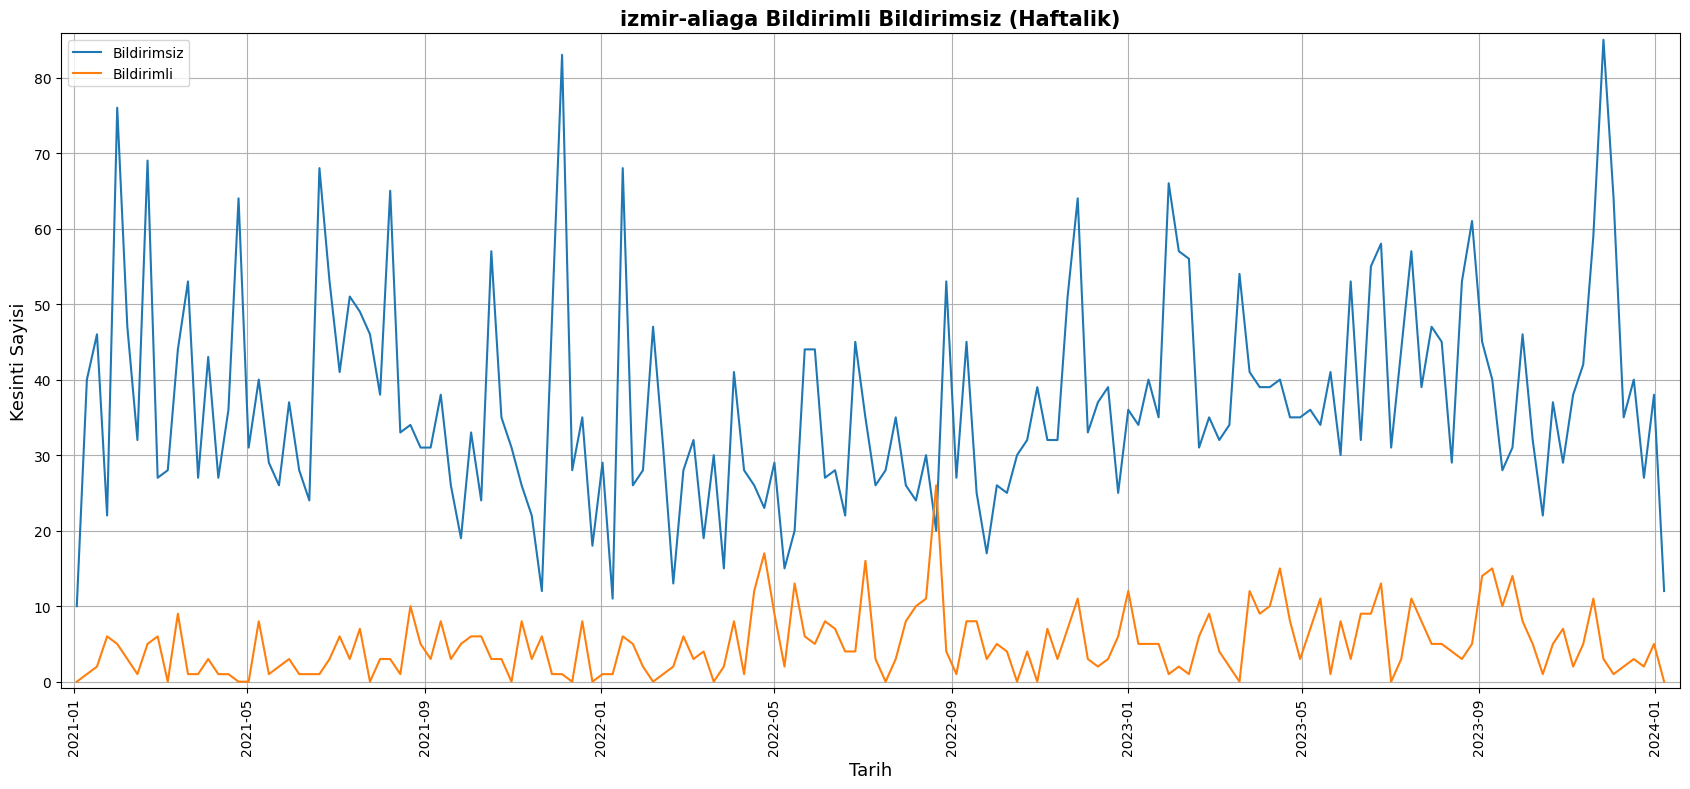

In [115]:
# 7-) Her ilcenin Bildirimli+Bildirimsiz kesinti grafigi
plt.figure(figsize=(17,8))
plt.plot(merged_all_week["izmir-aliaga"].index,merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], label="Bildirimsiz")
plt.plot(merged_all_week["izmir-aliaga"].index,merged_all_week["izmir-aliaga"]["Bildirimli_sum"], label="Bildirimli")
plt.xticks(rotation=90)
plt.title("izmir-aliaga Bildirimli Bildirimsiz (Haftalik)", fontweight="bold", fontsize=15)
plt.xlabel("Tarih", fontsize=13)
plt.ylabel("Kesinti Sayisi", fontsize=13)

plt.margins(0.01)
plt.legend()
plt.grid()
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig("./fig1.png")
plt.show()

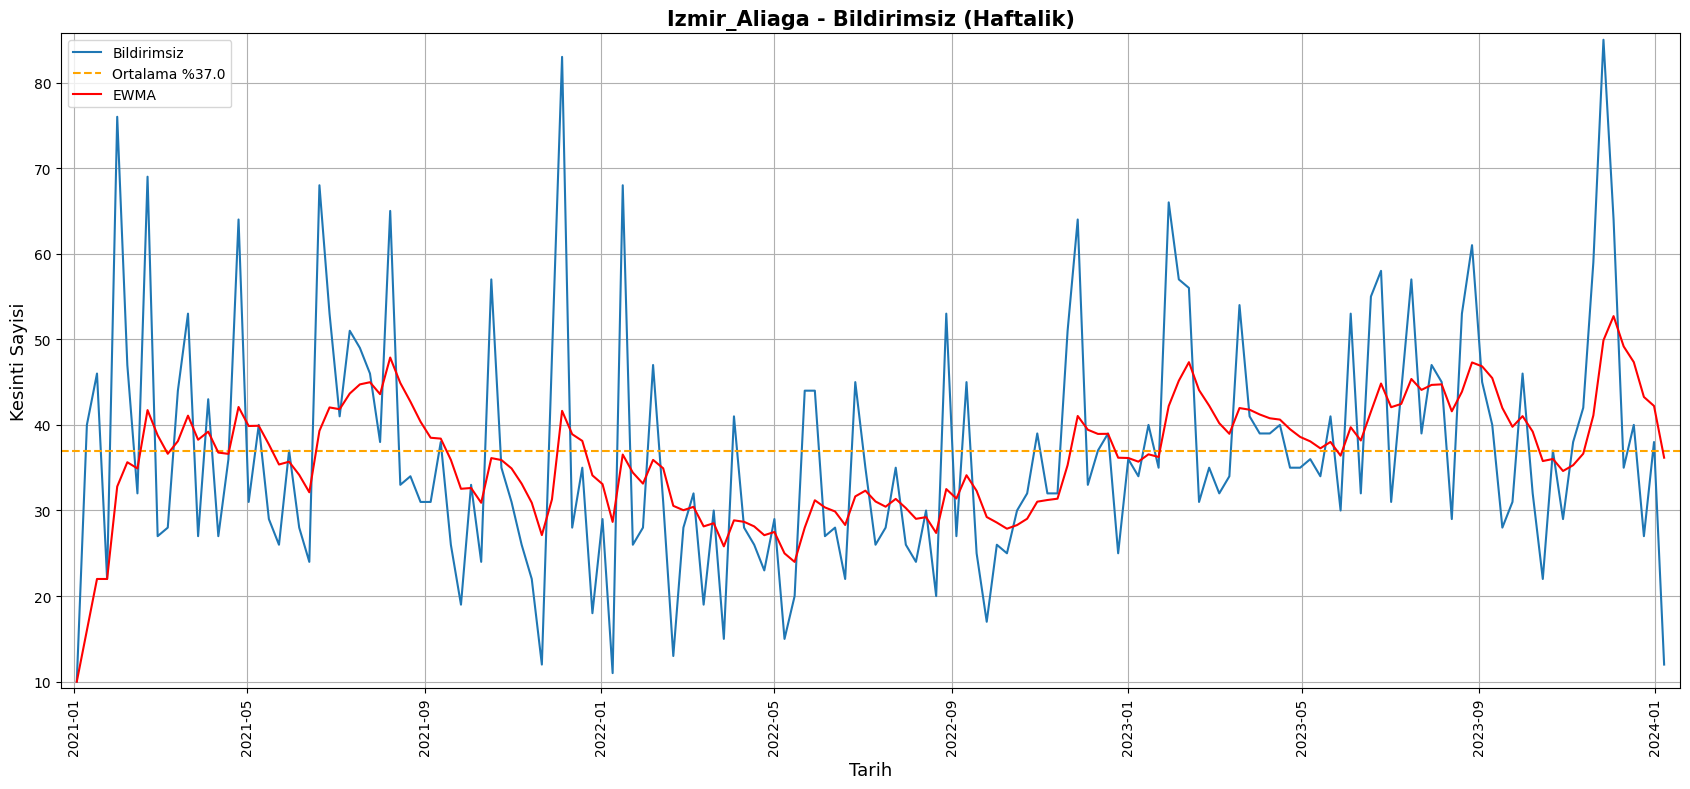

In [116]:
# 8-) Her ilcenin Bildirimsiz+MHO(EWMA) kesinti grafiği

plt.figure(figsize=(17,8))
plt.plot(merged_all_week["izmir-aliaga"].index,merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], label="Bildirimsiz")
plt.title("Izmir_Aliaga - Bildirimsiz (Haftalik)", fontweight="bold", fontsize=15)
plt.xticks(rotation=90)
plt.xlabel("Tarih", fontsize=13)
plt.ylabel("Kesinti Sayisi", fontsize=13)

window_size = 3  # Hareketli ortalama penceresi
merged_all_week["izmir-aliaga"]['Moving_Average'] = merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"].rolling(window=window_size, center=True).mean()
#plt.plot(merged_all_week["izmir-aliaga"]['Moving_Average'], label="MHO", color="black")

ortalama = merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"].mean()
plt.axhline(y=ortalama, color='orange', linestyle='--', label='Ortalama %{:.1f}'.format(ortalama))

"""
ayristirma2 = sm(merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], model="mul", period=4)

analiz = pd.concat([
    ayristirma2.observed,
    ayristirma2.trend,
    ayristirma2.seasonal,
    ayristirma2.observed/ayristirma2.seasonal # orijinal veri / S = T * E, regr. da üzerine tahmin yapılacak sey
], axis=1)
analiz.columns = ["Orijinal Gözlem", "Trend", "Mevsimsellik", "Mevsimsellik Düzeltme"]

indeks = np.arange(1,len(merged_all_week["izmir-aliaga"].index) + 1)


X = sa.add_constant(indeks)
model = sa.OLS(analiz["Mevsimsellik Düzeltme"], X)
sonuc = model.fit()
rsquared_value = sonuc.rsquared
y = pd.date_range(analiz.index[-1] + pd.DateOffset(weeks=4), periods=4,freq="W") # 4 tane ekstra ay ekle

yeni_satirlar = pd.DataFrame(index=y)
analiz = pd.concat([analiz, yeni_satirlar])

# not: bu degerleri ayarla
mev = [
    1.038656,
    0.973940,
    0.987404,
    1.038656
]

nan_indices = analiz.index[analiz['Mevsimsellik'].isna()]
for i, index in enumerate(nan_indices):
    if i < len(mev):
        analiz.at[index, 'Mevsimsellik'] = mev[i]
#print(analiz["Mevsimsellik"])

girdi = np.arange(1,len(merged_all_week["izmir-aliaga"].index) + 5)
regmodel = sonuc.predict(sa.add_constant(girdi))

analiz["Tahmin"] = analiz["Mevsimsellik"] * regmodel


print(analiz.head())

plt.text(analiz.index[0], max(analiz["Mevsimsellik Düzeltme"]), "R-squared value: {:.3f}".format(rsquared_value), fontsize=10, verticalalignment='top')
#plt.text(analiz.index[-1], max(analiz["Mevsimsellik Düzeltme"]), "R-squared value: {:.3f}".format(rsquared_value), fontsize=10, verticalalignment='top', horizontalalignment='left')
plt.scatter(analiz.index, analiz["Mevsimsellik Düzeltme"], label="Mevsimsellik Düzeltme", color="blue")
#plt.plot(analiz["Orijinal Gözlem"], label="Orijinal Gözlem", color="purple")
plt.plot(analiz.index, analiz["Tahmin"], label="Trend", color="red")
"""

alpha = 0.2  # Yumuşatma parametresi 
# formul : EMA_t = α × X_t + (1 - α) × EMA_{t-1}
merged_all_week["izmir-aliaga"]['EWMA'] = merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"].ewm(alpha=alpha, adjust=False).mean()

plt.plot(merged_all_week["izmir-aliaga"]['EWMA'], label="EWMA", color="red")


plt.margins(0.01)
plt.legend()
plt.grid()
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig("./fig2.png")
plt.show()

{6.0: 30.142857142857142, 6.508333333333334: 44.0, 6.670833333333333: 28.0, 7.0: 33.541666666666664, 7.05: 31.0, 7.079166666666667: 37.0, 7.104166666666667: 56.0, 7.108333333333333: 45.0, 7.191666666666666: 26.0, 7.291666666666667: 26.0, 7.4: 65.0, 7.454166666666667: 35.0, 7.9: 26.0, 8.05: 35.0, 8.345833333333333: 46.0, 9.504166666666666: 20.0, 9.608333333333333: 35.0, 10.095833333333333: 22.0, 10.212499999999999: 37.0, 10.425: 30.0, 10.429166666666667: 10.0, 10.4375: 38.0, 10.504166666666666: 40.0, 10.7625: 29.0, 10.966666666666667: 26.0, 11.454166666666666: 29.0, 11.733333333333333: 41.0, 11.75: 28.0, 11.841666666666667: 69.0, 12.229166666666666: 12.0, 12.412499999999998: 22.0, 12.5375: 31.0, 12.912500000000001: 51.0, 12.966666666666667: 40.0, 13.020833333333332: 44.0, 13.145833333333334: 28.0, 14.0: 38.0, 14.825: 26.0, 15.324999999999998: 11.0, 15.4375: 32.0, 17.266666666666666: 44.0, 17.358333333333334: 23.0, 17.645833333333336: 40.0, 17.708333333333332: 61.0, 18.170833333333334: 1

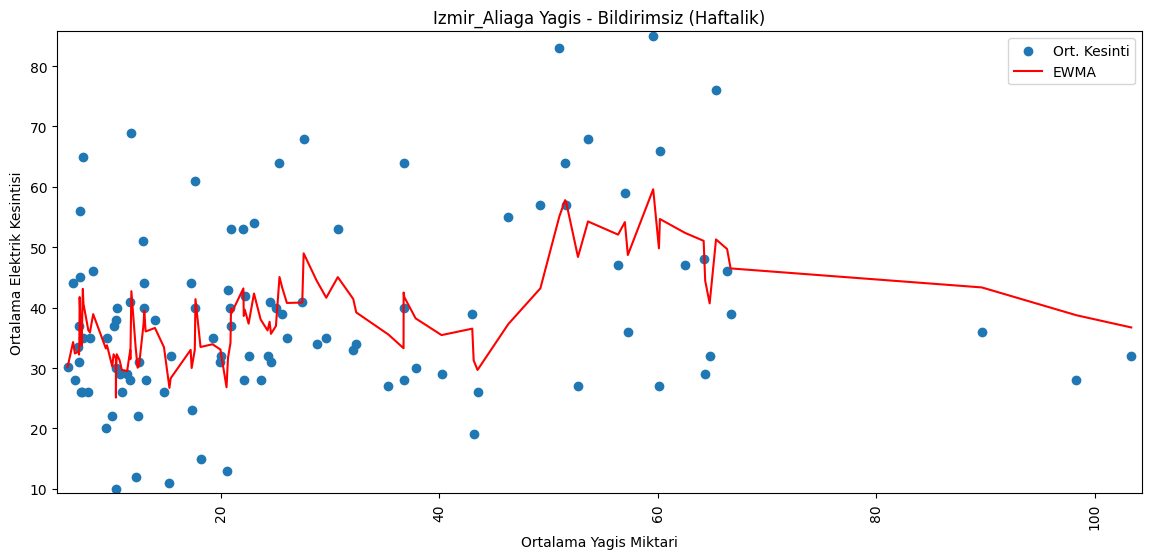

In [117]:
# 9-) ort. yagis miktarlari icin ort. kesinti sayisi grafigi (cok mantikli, gerekli degil)

yagis_dict = {}
for label,group in merged_all_week["izmir-aliaga"].groupby("Yagis"):
    yagis_dict[label] = group

yagis_dict_toplamlari = {}
for deger in yagis_dict.keys():
    yagis_dict_toplamlari[deger] = yagis_dict[deger]["Bildirimsiz_sum"].mean()
print(yagis_dict_toplamlari)

hesaplamalar = pd.DataFrame(list(yagis_dict_toplamlari.items()), columns=['Ort. Yagis', 'Ort. Kesinti'])
print(hesaplamalar)
window_size = 3  # Hareketli ortalama penceresi
hesaplamalar['Moving_Average'] = hesaplamalar["Ort. Kesinti"].rolling(window=window_size, center=True).mean()

alpha = 0.3  # Yumuşatma parametresi 
# formul : EMA_t = α × X_t + (1 - α) × EMA_{t-1}
hesaplamalar['EWMA'] = hesaplamalar["Ort. Kesinti"].ewm(alpha=alpha, adjust=False).mean()


plt.figure(figsize=(14,6))
#plt.bar(merged_all_week["izmir-aliaga"]["Yagis"],merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], width=0.05, label="Bildirimsiz")
plt.scatter(yagis_dict_toplamlari.keys(), yagis_dict_toplamlari.values(), label="Ort. Kesinti")
#plt.plot(hesaplamalar["Ort. Yagis"], hesaplamalar['Moving_Average'], label="MHO", color="red")
plt.plot(hesaplamalar["Ort. Yagis"], hesaplamalar['EWMA'], label="EWMA", color="red")
plt.margins(0.01)
plt.title("Izmir_Aliaga Yagis - Bildirimsiz (Haftalik)")
plt.xticks(rotation=90)
plt.xlabel("Ortalama Yagis Miktari")
plt.ylabel("Ortalama Elektrik Kesintisi")
plt.legend()
plt.show()

In [118]:
# 10-) test icin birlestirme islemleri

test = pd.read_csv("./test.csv", low_memory=False) # 47 ilce icin 28 gunluk veriler var. (tarih, ilce, bildirimli_sum)
#print(test)

dict_test :{str, pd.DataFrame} = {} # key olarak ilceleri, value olarak ilcelerin 4 ocak - 31 ocak arasi verilerini df olarak tutar
for label, group in test.groupby("ilce"):
    dict_test[label] = group

print(dict_test["izmir-konak"].head())

for name in dict_test.keys():

    tarihler = [] # duzgun tarihleri tutacak
    for date in dict_test[name]["tarih"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d")) 

    dict_test[name]["tarih"] = tarihler # duzeltilmis tarihleri ata

    dict_test[name].set_index("tarih", inplace=True) # tarih kolonunu index'e ata
    dict_test[name]["Tarih"] = dict_test[name].index # tarih kolonunu yeniden olustur
    dict_test[name] = dict_test[name].iloc[:, [2, 0, 1]] # kolon siralarini duzenle
    dict_test[name].columns = ["Tarih", "Ilce", "Bildirimli_sum"] # kolon isimlerini duzenle

print(dict_test["izmir-konak"].head())

dict_test_merged = {} # birlestirilenleri tutacak dict
for name in dict_test.keys():

    gecici = merge_holiday(dict_test[name], holiday) # test'e holiday ekle
    dict_test_merged[name] = merge_weather(gecici, ilce_weather_day[name]) # sonra weather'i ekle

    dict_test_merged[name].columns = ["Tarih", "Ilce", "Bildirimli_sum", # kolonlari tekrar isimlendir
    "Bayram_Flag", "Sicaklik", "Bagil_Nem", "Ruzgar_Hizi", "Yagis"]

    dict_test_merged[name]['Gün'] = range(1, len(dict_test_merged[name]) + 1) # gun kolonu ekle (1-28 arasi oluyor)

print(dict_test_merged["izmir-konak"])

          tarih         ilce  bildirimli_sum
30   2024-01-04  izmir-konak               0
77   2024-01-05  izmir-konak               1
124  2024-01-06  izmir-konak               4
171  2024-01-07  izmir-konak               0
218  2024-01-08  izmir-konak               1
                Tarih         Ilce  Bildirimli_sum
tarih                                             
2024-01-04 2024-01-04  izmir-konak               0
2024-01-05 2024-01-05  izmir-konak               1
2024-01-06 2024-01-06  izmir-konak               4
2024-01-07 2024-01-07  izmir-konak               0
2024-01-08 2024-01-08  izmir-konak               1
                Tarih         Ilce  Bildirimli_sum Bayram_Flag   Sicaklik  \
tarih                                                                       
2024-01-04 2024-01-04  izmir-konak               0         NaN  14.104167   
2024-01-05 2024-01-05  izmir-konak               1         NaN  14.183333   
2024-01-06 2024-01-06  izmir-konak               4         NaN  1

MAKINE OGRENMESI

In [119]:
#merged_all[]
# all_in_one
df = merged_all['izmir-konak']
df_test = dict_test_merged["izmir-konak"]
features = ['Bildirimli_sum','Sicaklik','Bayram_Flag','Sicaklik','Bagil_Nem','Ruzgar_Hizi','Yagis']
features_gun = ['Bildirimli_sum','Sicaklik','Bayram_Flag','Sicaklik','Bagil_Nem','Ruzgar_Hizi','Yagis','Gün']
features_output = ['Bildirimli_sum','Bildirimsiz_sum','Sicaklik','Bayram_Flag','Sicaklik','Bagil_Nem','Ruzgar_Hizi','Yagis']
output_var = df['Bildirimsiz_sum']
target = 'Bildirimsiz_sum'
ilceler = []

dict = {}
for label, group in train.groupby("ilce"):
    dict[label] = group
ilceler = list(dict.keys())

print(df)
print(ilceler)

                Tarih         Ilce  Bildirimsiz_sum  Bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   
...               ...          ...              ...             ...   
2023-12-30 2023-12-30  izmir-konak               10               1   
2023-12-31 2023-12-31  izmir-konak                9               0   
2024-01-01 2024-01-01  izmir-konak               11               0   
2024-01-02 2024-01-02  izmir-konak                9               1   
2024-01-03 2024-01-03  izmir-konak                8               1   

           Bayram_Flag   Sicaklik  Bagil_Nem  Ruzgar_Hizi      Yagis   Gün  

In [126]:
# ilcelerin numerizasyonu
columns_tonumerate = ['Bayram_Flag']
for column in columns_tonumerate:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])

# test csv dosyasi numerizasyon
for column in columns_tonumerate:
    encoder = LabelEncoder()
    df_test[column] = encoder.fit_transform(df_test[column])

# indexi gun yapmak gerek!!!!!
# gunu scale etmemek gerek!!!

# #Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform_gun = scaler.fit_transform(df[features_gun])
feature_transform_gun = pd.DataFrame(columns=features_gun, data=feature_transform_gun, index=df.index)

,Bildirimli_sum,Sicaklik,Bayram_Flag,Sicaklik,Bagil_Nem,Ruzgar_Hizi,Yagis,Gün
tarih,,,,,,,,
2021-01-01,0.0,0.355937,0.8,0.355937,0.933903,0.338286,0.002141,0.000000
2021-01-02,0.0,0.364770,1.0,0.364770,0.818796,0.205143,0.000000,0.000913
2021-01-03,0.0,0.340088,1.0,0.340088,0.802967,0.224571,0.023680,0.001826
2021-01-04,0.0,0.377371,1.0,0.377371,0.670044,0.454857,0.000000,0.002740
2021-01-05,0.0,0.380878,1.0,0.380878,0.844029,0.264571,0.175620,0.003653


In [127]:
# x-y test-train elde edimi
x = df[features]
y = output_var # = df["target_var"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=53, shuffle=True)

#Splitting to Training set and Test set --- burasi timeseries icin split
timesplit = TimeSeriesSplit(n_splits=15)
for train_index, test_index in timesplit.split(feature_transform):
        X_tr, X_te = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_tr, y_te = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
# LSTM

#Process the data for LSTM
trainX = np.array(X_tr)
testX = np.array(X_te)
X_tr = trainX.reshape(X_tr.shape[0], 1, X_tr.shape[1])
X_te = testX.reshape(X_te.shape[0], 1, X_te.shape[1])

#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

#Model Training
history=lstm.fit(X_tr, y_tr, epochs=100, batch_size=8, verbose=1, shuffle=False)

#LSTM Prediction
y_pr= lstm.predict(X_te)

# Predicted vs True Adj Close Value – LSTM  --burasi copy paste
plt.plot(y_te, label='True Value')
plt.plot(y_pr, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# test_pred = lstm.predict(gercek test)
# csv ye yazdir vs vs

In [130]:
# KNN

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=53, shuffle=True)

k=8
neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
neigh.fit(X_train, y_train)

y_hat = neigh.predict(X_test)

test_accuracy = neigh.score(X_test, y_test)

print("Test accuracy with class weights:", test_accuracy)
print("egitim verisi dogrulugu ", metrics.accuracy_score(y_train,neigh.predict(X_train)))
print("test verisi dogrulugu ", metrics.accuracy_score(y_test,y_hat))

# test tahmin --tahmini yazmada sikinti cikiyor tek bir ilceden tahmin yapinca iste
# y_hat = neigh.predict(df_test[features])
# submission = pd.read_csv("sample_submission.csv", low_memory=False)
# submission.iloc[:, 2] = y_hat
# submission.to_csv("knnsubmission.csv", index=False)

# optimal k degeri

# # Define the range of k values to try
# k_values = range(1, 21)

# # Perform cross-validation for each value of k
# cv_scores = []
# for k in k_values:
#     neigh = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(neigh, X_train, y_train, cv=5)
#     cv_scores.append(scores.mean())

# # Find the optimal value of k with the highest cross-validation score
# optimal_k = k_values[cv_scores.index(max(cv_scores))]
# print("Optimal k:", optimal_k)

# # Train the model with the optimal k value
# neigh = KNeighborsClassifier(n_neighbors=optimal_k).fit(X_train, y_train)
# test_accuracy = neigh.score(X_test, y_test)
# print("Test accuracy with optimal k:", test_accuracy)
# print("")

Test accuracy with class weights: 0.10909090909090909
egitim verisi dogrulugu  1.0
test verisi dogrulugu  0.10909090909090909


IndexError: iloc cannot enlarge its target object

In [ ]:
# NN
# alinan kaynakta goruntu isleme icin kullaniliyordu bazi uyusmazliklar olabilir
# Cast the records into float values 
# x_train = x_train.astype('float32') 
# x_test = x_test.astype('float32') 

print("Feature matrix:", x_train.shape) 
print("Target matrix:", x_test.shape) 
print("Feature matrix:", y_train.shape) 
print("Target matrix:", y_test.shape)  
model = Sequential([ 
    Flatten(input_shape=(x_train.shape)), 
    
    # dense layer 1 
    Dense(256, activation='sigmoid'),   
    
    # dense layer 2 
    Dense(128, activation='sigmoid'),  
    
    # output layer 
    Dense(10, activation='sigmoid'),   
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

model.fit(x_train, y_train, epochs=10,  
          batch_size=2000,  
          validation_split=0.2)

results = model.evaluate(x_test,  y_test, verbose = 0) 
print('test loss, test acc:', results)

Sequential() specifies that the network is a linear stack of layers

model.add() adds the hidden layer.

Dense means that neurons between layers are fully connected

input_dim defines the number of features in the training dataset

activation defines the activation function

loss selects the cost function

optimizer selects the learning algorithm

metrics selects the performance metrics to be saved for further analysis

model.fit() initialize the training

In [ ]:
# NN2

X = df[features] #features
y = df['target_var'] #expected values

model = Sequential()
model.add(Dense(16, input_dim=2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['binary_accuracy', 'mean_squared_error'])

history = model.fit(X, y, epochs=3000, verbose=0)

y_pred = model.predict(X).round()
num_correct_predictions = (y_pred == y).sum()
accuracy = (num_correct_predictions / y.shape[0]) * 100
print('Multi-layer perceptron accuracy: %.2f%%' % accuracy)